# Randomly sample around the solution ball

In [1]:
import rebound
from spock import FeatureClassifier
feature_model = FeatureClassifier()

[17:02:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1662013816914/work/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


Values from Suárez Mascareño + 2022

In [2]:
from scipy.stats import uniform, norm, truncnorm
import astropy.units as u
import numpy as np

Mstar = 1.095 # + 0.049 - 0.047
Nplanets = 4
#b,c,d,e
pers = [24.1399, 8.24892, 12.4058, 40.2]
pers_err = [0.0015, 0.00083, 0.0018, 1.0]

eccs = [0.134, 0.30, 0.20, 0.10]
eccs_err = [0.075, np.nan, np.nan, 0.091]

mps = [0.64, 0.24, 0.31, 1.16]
mps_err = [0.19, np.nan, np.nan, 0.30]

In [3]:
def setup_sim(mps, pers, eccs):
    assert len(mps)==len(pers)==len(eccs)==Nplanets
    sim = rebound.Simulation()
    sim.units = ["msun", "m", "d"]
    sim.add(m=Mstar)
    for i in range(Nplanets):
        sim.add(m=mps[i], P=pers[i], e=eccs[i])
    sim.move_to_com()
    return sim

In [4]:
setup_sim(mps,pers,eccs)

<rebound.simulation.Simulation object at 0x7f010f6433b0, N=5, t=0.0>

vectorized samples

In [5]:
Nsamples = 1_000
pvec=[norm(loc=pers[i], scale=pers_err[i]).rvs(size=Nsamples) for i in range(Nplanets)]
pvec=np.c_[pvec].T
pvec

array([[24.1397454 ,  8.24931753, 12.40472112, 41.32747337],
       [24.14263098,  8.24855164, 12.40559675, 41.32019457],
       [24.13993699,  8.24875098, 12.40351347, 39.45651098],
       ...,
       [24.14026191,  8.24741398, 12.40703423, 39.23449659],
       [24.13985037,  8.24799718, 12.40750787, 39.76731333],
       [24.14005971,  8.24838343, 12.4062002 , 40.54854811]])

In [7]:
evec=[]
for i in range(Nplanets):
    mu = eccs[i]
    sigma = eccs_err[i]
    if sigma is np.nan:
        v=uniform(loc=0, scale=mu).rvs(size=Nsamples)
    else:
        lower = 0
        upper = 1
        a = (lower - mu) / sigma
        b = (upper - mu) / sigma
        v=truncnorm(a=a, b=b, loc=mu, scale=sigma).rvs(size=Nsamples)
    evec.append(v)
evec=np.c_[evec].T
evec

array([[0.15751041, 0.10653704, 0.02583765, 0.0979088 ],
       [0.13375634, 0.2273373 , 0.0591978 , 0.14907379],
       [0.04415909, 0.0268694 , 0.17506571, 0.08437386],
       ...,
       [0.06822686, 0.1961795 , 0.19703728, 0.07889747],
       [0.22541157, 0.03308455, 0.01345135, 0.06540237],
       [0.07039698, 0.10097023, 0.04438891, 0.01489131]])

In [9]:
Mj2Ms = u.Mjup.to(u.Msun)

mvec=[]
for i in range(Nplanets):
    mu, sigma = mps[i], mps_err[i]
    if sigma is np.nan:
        v=uniform(loc=0, scale=mu).rvs(size=Nsamples)*Mj2Ms
    else:
        lower = 1e-6
        upper = mu+5*sigma
        a = (lower - mu) / sigma
        b = (upper - mu) / sigma
        v=truncnorm(a=a, b=b, loc=mu, scale=sigma).rvs(size=Nsamples)*Mj2Ms
    mvec.append(v)
mvec=np.c_[mvec].T
mvec

array([[6.15084952e-04, 1.41693608e-04, 1.91032577e-04, 1.20230756e-03],
       [6.46365846e-04, 1.47831023e-04, 1.65451502e-04, 1.06076035e-03],
       [8.87699509e-04, 1.83838971e-04, 2.88886044e-05, 1.38191211e-03],
       ...,
       [4.93931501e-04, 6.62494692e-05, 2.85221546e-04, 9.27606793e-04],
       [7.05713469e-04, 3.49138025e-06, 1.40630916e-04, 1.04515193e-03],
       [9.54244771e-04, 8.55636917e-05, 2.40414756e-04, 9.02779668e-04]])

In [10]:
assert mvec.all()

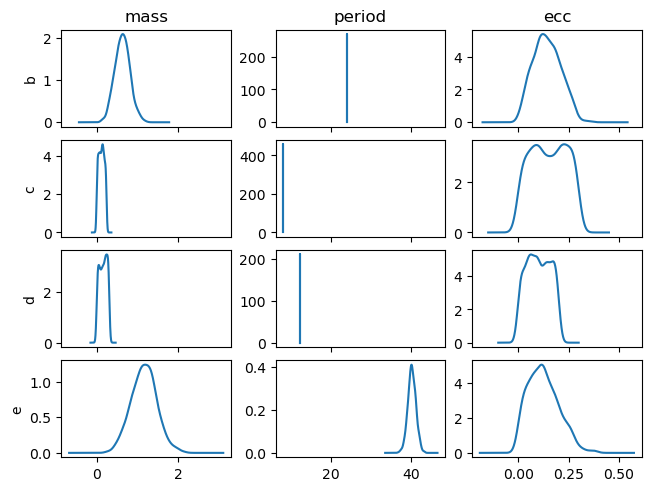

In [11]:
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

fig,axes = pl.subplots(Nplanets, 3, sharex='col', constrained_layout=True)

planets = "b c d e".split()

fac = u.Msun.to(u.Mjup)
for i,(lbl,par) in enumerate(zip(["mass","period","ecc"],[mvec*fac,pvec,evec])):
    df = pd.DataFrame(par, columns=planets)
    for j,p in enumerate(planets):
        ax=axes[j,i]
        df[p].plot.kde(ax=ax)
        if j==0:
            ax.set_title(lbl)
        if i==0:
            ax.set_ylabel(p)       
        else:
            ax.set_ylabel("")       

## Exploring around the solution ball

In [12]:
#multi threading ex:
#https://github.com/dtamayo/spock/blob/master/jupyter_examples/ComparingToNbody.ipynb

sims = [setup_sim(mvec[i],pvec[i],evec[i]) for i in range(Nsamples)]

In [13]:
results = feature_model.predict_stable(sims, n_jobs=40)
results

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.2047812 , 0.00789564, 0.        , 0.        ,
       0.        , 0.        , 0.03904944, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04104789,
       0.        , 0.        , 0.02295419, 0.        , 0.        ,
       0.06064507, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03125108, 0.04688123, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00546592, 0.        ,
       0.01805021, 0.        , 0.        , 0.01004676, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### "stable solutions"

In [14]:
#non-zero solutions
idx = [True if results[i]>0.1 else False for i in range(Nsamples)]
results[idx]

array([0.2047812 , 0.2604229 , 0.18440332, 0.16216736, 0.17245726,
       0.17238186, 0.6342653 ], dtype=float32)

In [15]:
len(results[idx])

7

In [17]:
for i in range(len(results[idx])):
    ms=np.c_[mvec,pvec,evec][idx][i,:4]*u.Msun.to(u.Mjup)
    ps=np.c_[mvec,pvec,evec][idx][i,4:8]
    es=np.c_[mvec,pvec,evec][idx][i,8:12]
    print(f"==Solution {i+1}: (prob={results[idx][i]:.2f})==")
    print("m1={:.2f}, m2={:.2f}, m3={:.2f}, m4={:.2f}".format(*ms))
    print("p1={:.2f}, p2={:.2f}, p3={:.2f}, p4={:.2f}".format(*ps))
    print("e1={:.2f}, e2={:.2f}, e3={:.2f}, e4={:.2f}\n".format(*es))

==Solution 1: (prob=0.20)==
m1=0.55, m2=0.11, m3=0.24, m4=0.89
p1=24.14, p2=8.25, p3=12.41, p4=40.29
e1=0.07, e2=0.24, e3=0.06, e4=0.08

==Solution 2: (prob=0.26)==
m1=0.47, m2=0.19, m3=0.20, m4=0.76
p1=24.14, p2=8.25, p3=12.40, p4=39.87
e1=0.23, e2=0.23, e3=0.06, e4=0.23

==Solution 3: (prob=0.18)==
m1=0.52, m2=0.11, m3=0.30, m4=0.87
p1=24.14, p2=8.25, p3=12.41, p4=40.26
e1=0.17, e2=0.27, e3=0.04, e4=0.15

==Solution 4: (prob=0.16)==
m1=0.37, m2=0.03, m3=0.04, m4=1.08
p1=24.14, p2=8.25, p3=12.41, p4=41.15
e1=0.10, e2=0.11, e3=0.05, e4=0.12

==Solution 5: (prob=0.17)==
m1=0.45, m2=0.10, m3=0.24, m4=1.37
p1=24.14, p2=8.25, p3=12.41, p4=40.08
e1=0.18, e2=0.17, e3=0.01, e4=0.14

==Solution 6: (prob=0.17)==
m1=0.64, m2=0.03, m3=0.06, m4=0.97
p1=24.14, p2=8.25, p3=12.41, p4=41.17
e1=0.13, e2=0.22, e3=0.03, e4=0.13

==Solution 7: (prob=0.63)==
m1=0.53, m2=0.00, m3=0.17, m4=1.08
p1=24.14, p2=8.25, p3=12.40, p4=41.30
e1=0.08, e2=0.25, e3=0.04, e4=0.09

